# ProtVI

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

import data_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics
from scp.benchmark_models import run_protDP

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s load the data.

In [2]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

## PROTVI

### Training

Let's now train the model.

In [3]:
adata.X = adata.layers["main"].copy()
adata.X[np.isnan(adata.X)] = 0

In [4]:
PROTVI.setup_anndata(adata, batch_key="Plate", prior_continuous_covariate_keys=["log Qalb"])
#PROTVI.setup_anndata(adata, batch_key="Plate", prior_continuous_covariate_keys=["log Qalb"], prior_categorical_covariate_keys=["Plate"])

model = PROTVI(adata, log_variational=False, decoder_type="selection")
#model.view_anndata_setup()

Let's train the model.

In [5]:
model.train(max_epochs=1800, plan_kwargs={"mechanism_weight": 1}, check_val_every_n_epoch=1) #, plan_kwargs={"min_kl_weight": 8, "max_kl_weight": 8})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1800/1800: 100%|██████████| 1800/1800 [27:36<00:00,  1.23it/s, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.38e+3] 

`Trainer.fit` stopped: `max_epochs=1800` reached.


Epoch 1800/1800: 100%|██████████| 1800/1800 [27:36<00:00,  1.09it/s, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.38e+3]


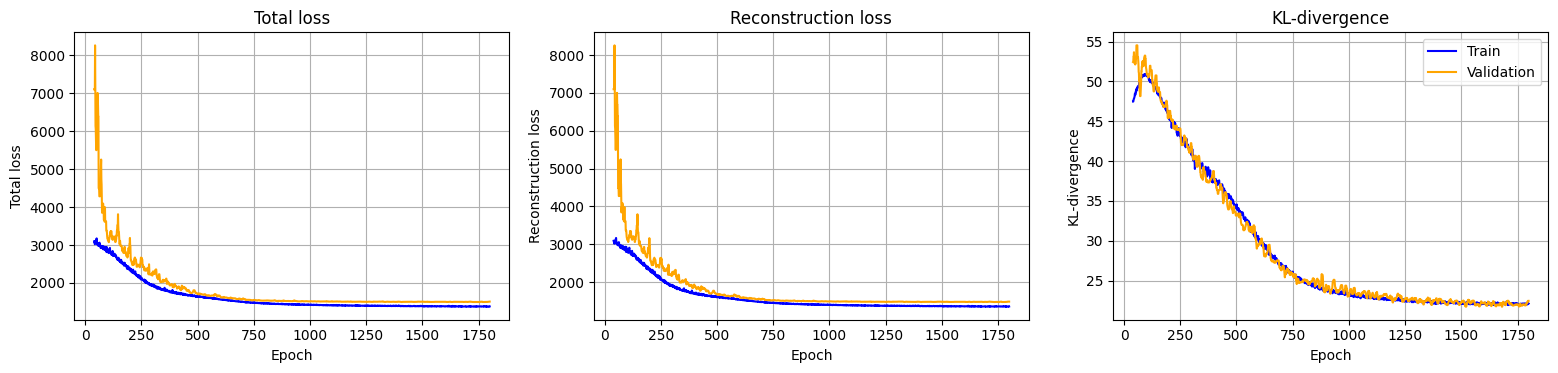

In [6]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

### Evaluation on training set (MAIN)

In [7]:
x_est, p_est = model.impute(n_samples=10)

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Let's compute compute some common performance metrics to compare with other models later.

In [8]:
common_metrics = sup.compute_common_metrics(x_main, x_pilot, x_est)
sup.save_dict_to_results(common_metrics, "protvi selection.pkl")

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

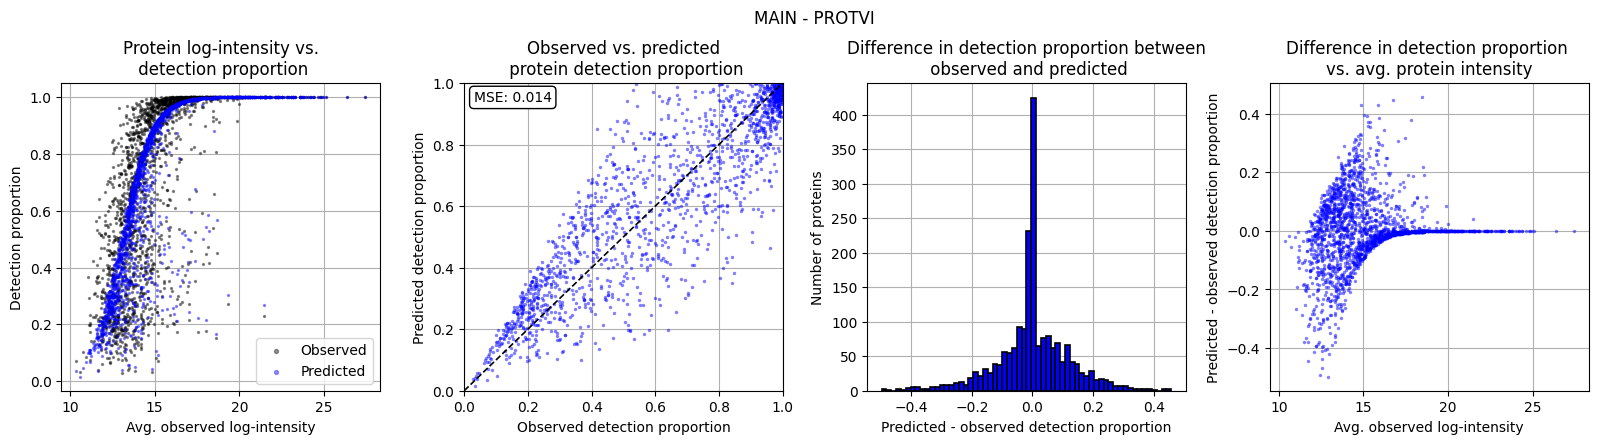

In [9]:
pl.plot_protein_detection_proportion_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

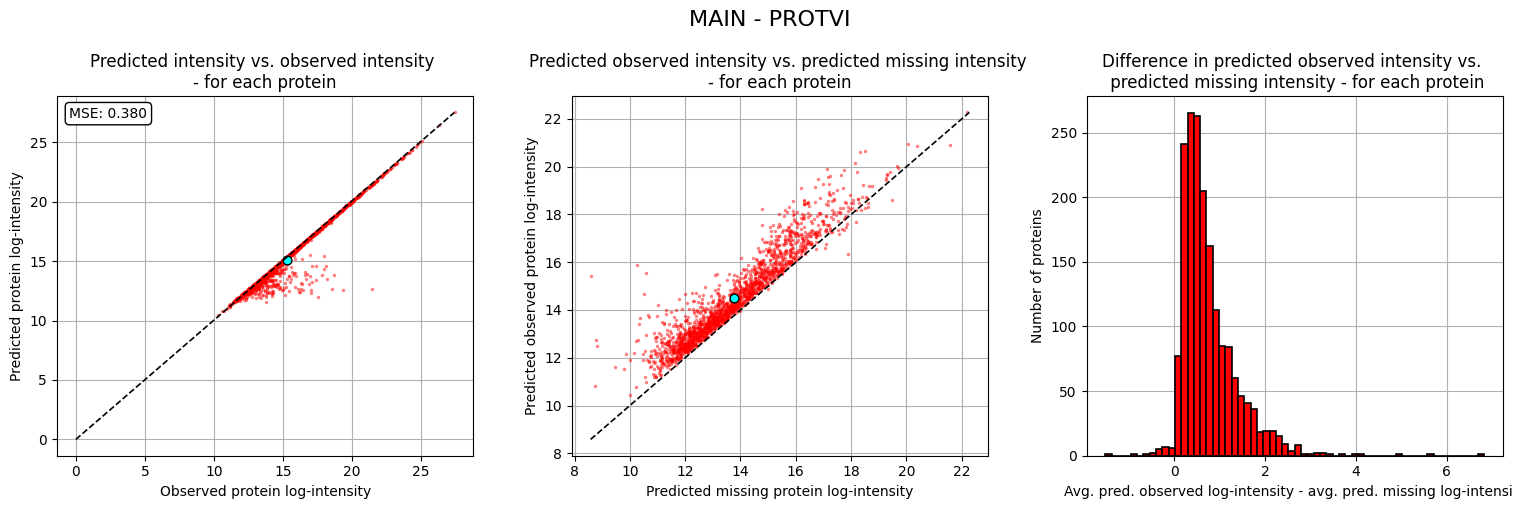

In [10]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

Let's look at the latent space.

In [11]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

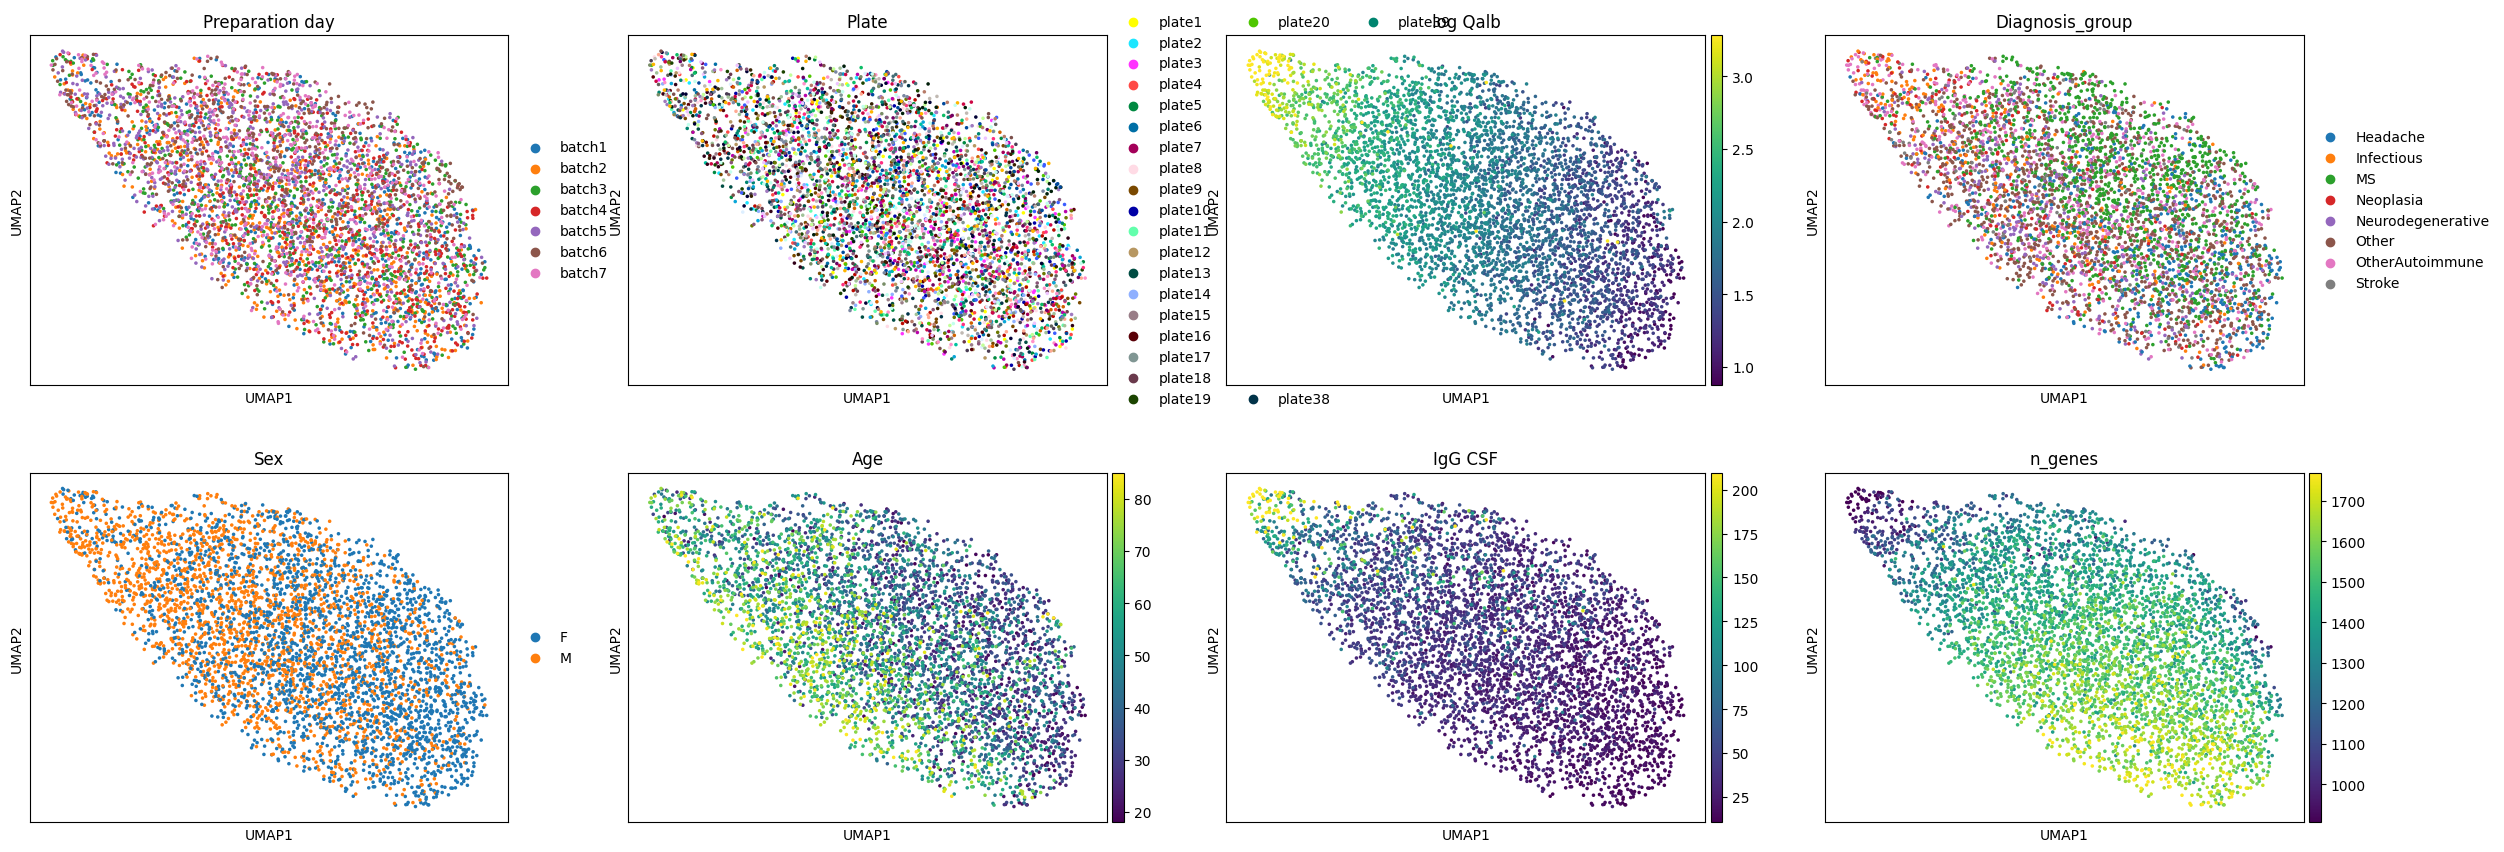

In [12]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Preparation day", "Plate", "log Qalb", "Diagnosis_group", "Sex", "Age", "IgG CSF", "n_genes"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

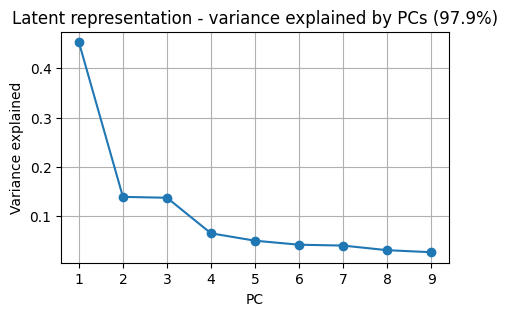

In [13]:
latent_projection, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.arange(1, latent_projection.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_projection.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title(f"Latent representation - variance explained by PCs ({np.sum(var_ratio[:10])*100:.1f}%)")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the patient means and variances.

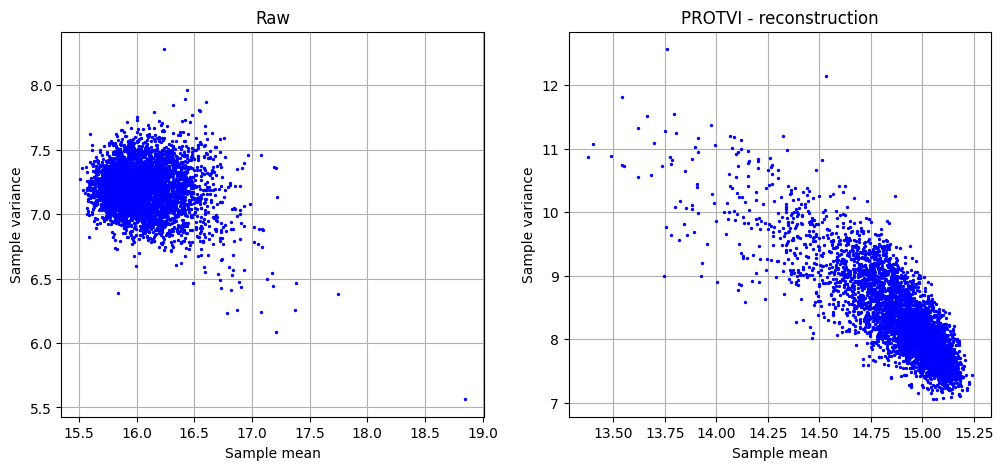

In [14]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["main"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

### Evaluation on validation set (PILOT)

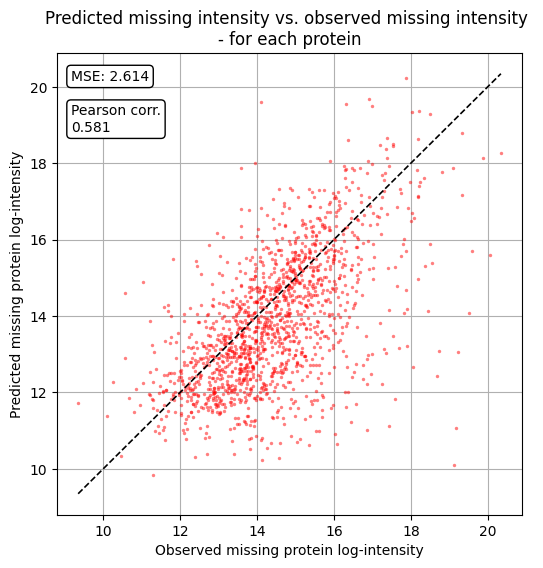

In [15]:
sup.scatter_pilot_model_by_protein(adata.layers["main"], adata.layers["pilot"], x_est)

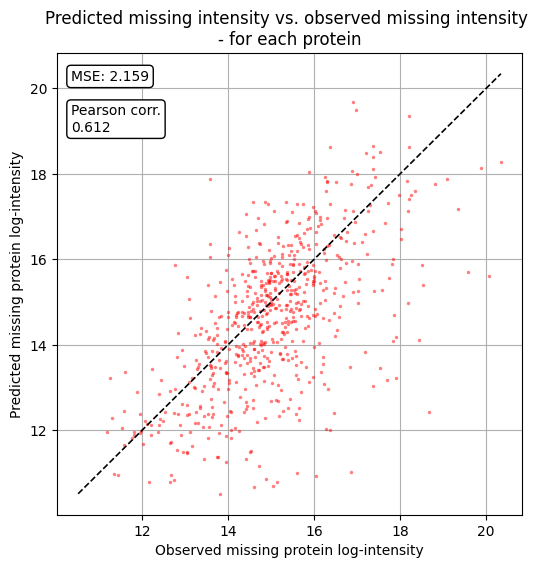

In [16]:
min_correlation = 0.4
n_min_protein_overlap = 15

corrs = metrics.compare_intensities_protein_wise(adata.layers["main"], adata.layers["pilot"], n_min_overlap=n_min_protein_overlap)
protein_idx = corrs["protein_idx"][np.array(corrs["pearson"]) > min_correlation]

sup.scatter_pilot_model_by_protein(adata.layers["main"][:, protein_idx], adata.layers["pilot"][:, protein_idx], x_est_miss[:, protein_idx])

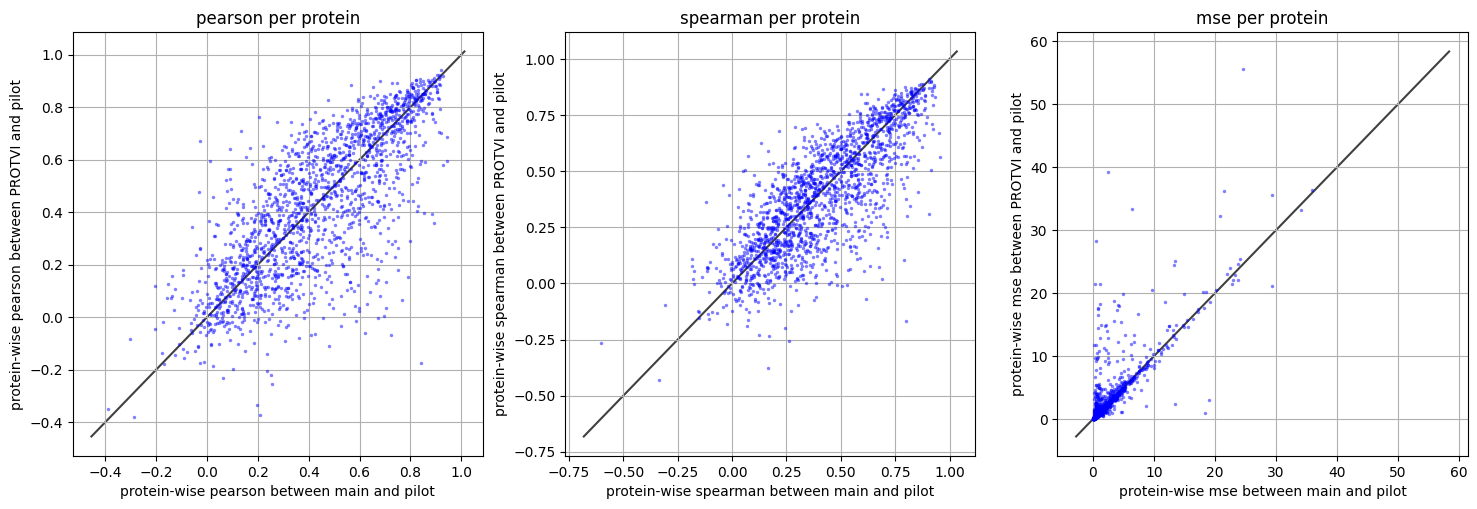

In [17]:
sup.scatter_main_pilot_model(adata.layers["main"], adata.layers["pilot"], x_est, n_min_protein_overlap=n_min_protein_overlap)

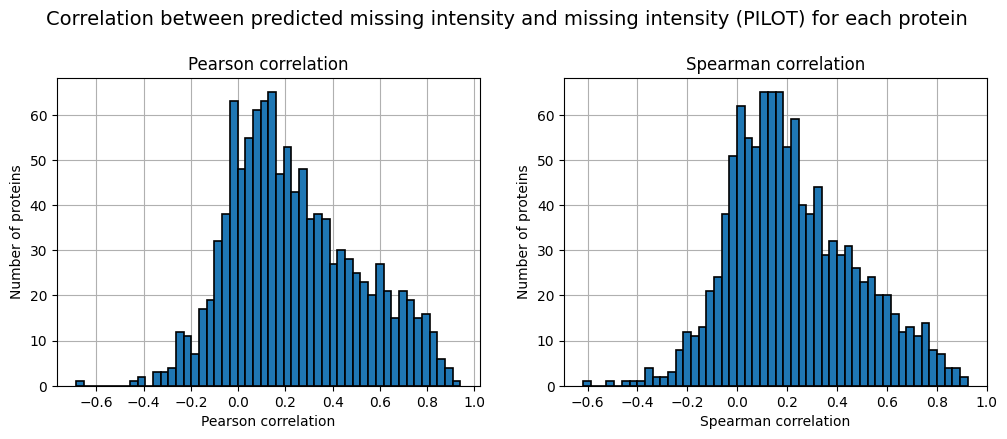

In [18]:
x_pilot = adata.layers["pilot"]

corrs = metrics.compare_intensities_protein_wise(x_est_miss, x_pilot, n_min_overlap=n_min_protein_overlap)

fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
fig.suptitle("Correlation between predicted missing intensity and missing intensity (PILOT) for each protein", fontsize=14, y=1.05)

ax = axes[0]
ax.hist(corrs["pearson"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(corrs["spearman"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

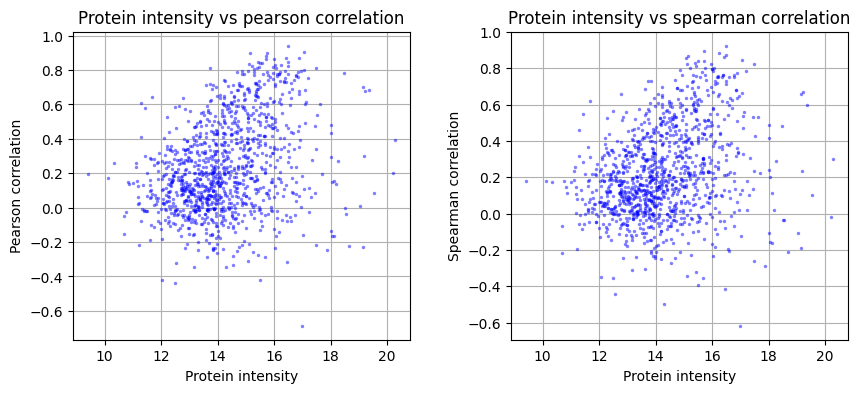

In [19]:
x_overlap = np.nanmean(x_pilot[:, corrs["protein_idx"]], axis=0)

fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.scatter(x_overlap, corrs["pearson"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs pearson correlation")
ax.set_xlabel("Protein intensity")
ax.set_ylabel("Pearson correlation")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(x_overlap, corrs["spearman"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs spearman correlation")
ax.set_xlabel("Protein intensity")
ax.set_ylabel("Spearman correlation")
ax.grid(True)
ax.set_axisbelow(True)

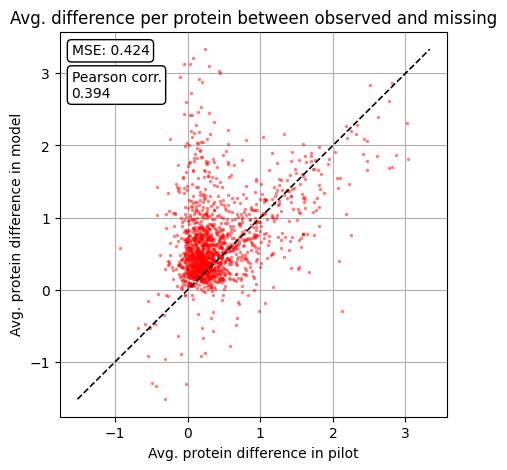

In [20]:
sup.scatter_difference_observed_and_missing_by_protein(x_pilot, x_main, x_est)

## protDP

Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.

### Training

In [21]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

In [22]:
protdp_result = run_protDP(adata, "main")

In [23]:
x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

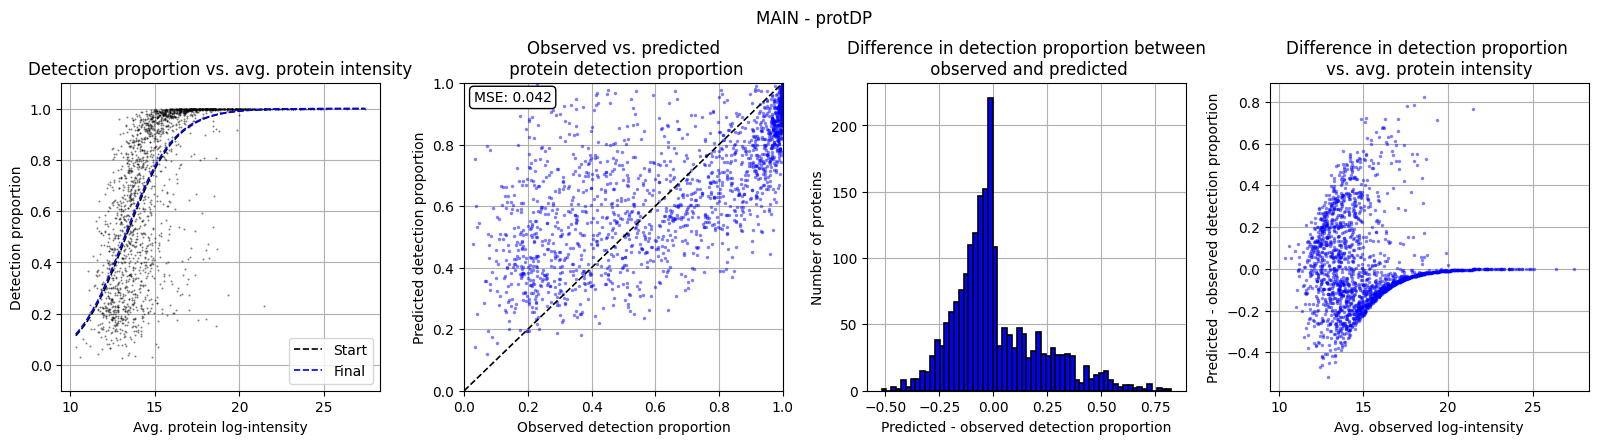

In [24]:
pl.plot_protein_detection_proportion_panel_protDP(x_main, protdp_result, title="MAIN - protDP")

In [25]:
common_metrics = sup.compute_common_metrics_protDP(x_main, x_pilot, protdp_result["mu_obs"], protdp_result["mu_mis"])
sup.save_dict_to_results(common_metrics, "protDP.pkl")

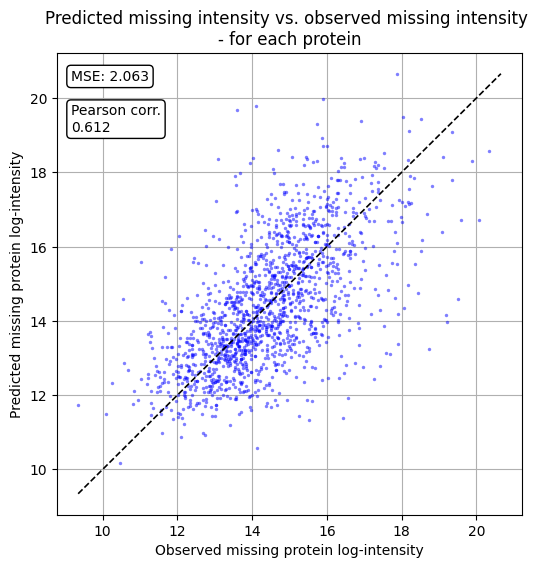

In [26]:
miss_mask = np.logical_and(np.isnan(x_main), ~np.isnan(x_pilot))
protein_mask = miss_mask.any(axis=0)

x_pilot_sub = x_pilot.copy()
x_pilot_sub[~miss_mask] = np.nan
x_pilot_sub = x_pilot_sub[:, protein_mask]

x_est_protein = protdp_result["mu_mis"][protein_mask]
x_pilot_protein = np.nanmean(x_pilot_sub, axis=0)

pl.scatter_compare_protein_missing_intensity(x_pilot_protein, x_est_protein, color="blue")

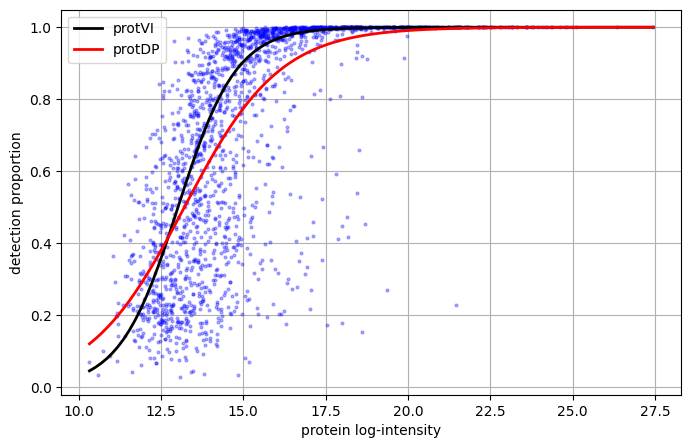

In [27]:
slope, intercept = model.module.decoder.get_mask_logit_weights()

if (slope is not None) and (intercept is not None):
    x_protein = np.nanmean(x_main, axis=0)
    p_protein = 1 - np.mean(np.isnan(x_main), axis=0)
    p_est_protein = p_est.mean(axis=0)

    fig, ax = plt.subplots(figsize=(8, 5), ncols=1)

    pl.scatter_protein_detection_proportion_and_intensity(x_main, ax=ax)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="black", label="protVI", linewidth=2)

    intercept, slope = protdp_result["beta"]
    ys = sigmoid(slope * xs + intercept)
    ax.plot(xs, ys, color="red", label="protDP", linewidth=2)
    ax.legend()